<h3>Cross-validation</h3>
<p>In this notebook, we perform a cross-validation to try and choose the polynomial order for some synthetic data.</p>
<p>The loss (in our case, this is equal to the squared error) on the training data will always decrease as we make the model more complex, and therefore cannot be used to select how complex the model ought to be. In some cases we may be lucky enough to have an independent test set for model validation but often we will not. In a cross-validation procedure (CV) we split the data into $K$ folds, and train $K$ different models, each with a different data fold removed. This removed fold is used for testing and the performance is averaged over the $K$ different folds.</p>
<p>This process is illustrated in the following figure:</p>
<img src="files/cvdiagram.png">
<p>We start by generating two datasets - one on which we will perform the CV, and a second independent test set.</p>

In [1]:
import numpy as np
N = 100
x = 10*np.random.rand(N,1) - 5
t = 5*x**3 - x**2 + x + 150*np.random.randn(N,1)
N_test = 200
x_test = np.linspace(-5,5,N_test)[:,None]
t_test = 5*x_test**3 - x_test**2 + x_test + 150*np.random.randn(N_test,1)


<p>We now loop over model order (from 0th up to 10th order polynomials) and for each order, perform a $K=10$ fold CV. For each fold-order combintaion we compute the mean squared loss on the training data, the mean squared loss on the held out fold and the mean squared loss on the independent test set.</p>
<p>Note that in many cases, it would be sensible to randomise the order of the data before placing it into the folds.</p>

In [2]:
max_order = 10
X = []
X_test = []
K = 10
sizes = np.tile(np.floor(N/10),(1,K))
sizes[-1] = sizes[-1] + N - sizes.sum()
c_sizes = np.hstack((0,np.cumsum(sizes)))
X = np.ones_like(x)
X_test = np.ones_like(x_test)
cv_loss = np.zeros((K,max_order+1))
ind_loss = np.zeros((K,max_order+1))
train_loss = np.zeros((K,max_order+1))

for k in range(max_order+1):
    for fold in range(K):
        X_fold = X[c_sizes[fold]:c_sizes[fold+1],:]
        X_train = np.delete(X,np.arange(c_sizes[fold],c_sizes[fold+1],1),0)
        t_fold = t[c_sizes[fold]:c_sizes[fold+1]]
        t_train = np.delete(t,np.arange(c_sizes[fold],c_sizes[fold+1],1),0)
        w = np.linalg.solve(np.dot(X_train.T,X_train),np.dot(X_train.T,t_train))
        fold_pred = np.dot(X_fold,w)
        cv_loss[fold,k] = ((fold_pred - t_fold)**2).mean()
        ind_pred = np.dot(X_test,w)
        ind_loss[fold,k] = ((ind_pred - t_test)**2).mean()
        train_pred = np.dot(X_train,w)
        train_loss[fold,k] = ((train_pred - t_train)**2).mean()
    X = np.hstack((X,x**(k+1)))
    X_test = np.hstack((X_test,x_test**(k+1)))


<p>Finally, we plot the mean performance in each case (where the mean is taken over folds).</p>

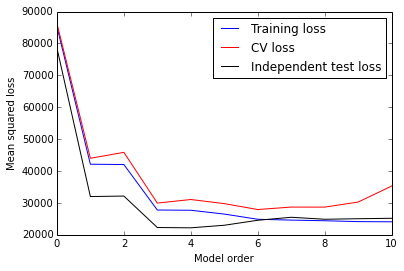

In [3]:
import pylab as plt
%matplotlib inline
order = np.arange(max_order+1)
plt.plot(order,train_loss.mean(axis=0),'b-',label="Training loss")
plt.plot(order,cv_loss.mean(axis=0),'r-',label="CV loss")
plt.plot(order,ind_loss.mean(axis=0),'k',label="Independent test loss")
plt.legend()
plt.xlabel('Model order')
plt.ylabel('Mean squared loss')

<p>As expected, training loss (blue) always decreaes. The CV loss doesn't, and comes to a minimum at around 3rd order (this will not always be the case - it depends on the dataset generated at the start of the notebook). The independent loss typically has a more well-defined minimum.</p>